Данный блокнот содержит все имеющиеся на текущий момент сведения по работе над датасетом первых воспоминаний 'reminiscence'.

Вопросы исследования

Черновой план дальнейшей работы:
- Было бы полезно подробнее рассказать о сборе воспоминаний - какие номера какому типу сбора соответствуют, где был их источник - воспоминания 469-643 собраны преимущественно через Google-форму. 
- Преобразование в pandas строковых значений чисел в числовые
- Описать разделы построений распределений для каждой категории таблицы
- Построение распределения возрастов всех воспоминаний (не минимальных)
- Инструмент для объектов вида "объект (общая группа объектов)"
- Было бы удобно, если бы исходный датафрейм был глобальной переменной
- Распределения записей по числовым параметрам:
    - Возраст (общий инструмент для разных граф - с целью построения корреляций). Для пары "возраст-воспоминание" имеет смысл построить распределения самых ранних воспоминаний, если указан диапазон - то указывать среднюю точку с интервалом ()
    - Активное-пассивное
    - Наличие/отсутствие лиц и вообще инструмент заполненности поля (сколько символов "-" и сколько заполненных)
- pymorphy: разбивать составные воспоминания по отступу в виде одной строки или специальному символу. Отношение между частями речи. Что преобладает в коротких воспоминаниях? Анализ по парам младший/старший, мама/пара, бабушка/дедушка.
- pymorhy:
- Функция генерации текста из чередующихся "малых" и "крупных" воспоминаний для облегчения чтения в виде текста

# Считывание данных из Google Sheet

Набор данных оформлен [в виде электронной таблицы на Google Drive](https://docs.google.com/spreadsheets/d/1KSirtO9hZSmVst--GiqsBPYk6hX-xOCI-SolgiafjcI/edit?usp=sharing). Доступ к Google Sheets API осуществляется в соответствии с [документацией API для Python](https://developers.google.com/sheets/api/quickstart/python).

Импортируем данные учетной записи и преобразуем в объект Pandas:

In [1]:
%matplotlib inline

# встроенные
import json
import os.path
import pickle       # хранение токенов
import collections  # используется для подсчета
import re           # обработка текстовой составляющей

# сторонние
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pymorphy2    # обработка текстовой составляющей
    
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request

SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']
SPREADSHEET_ID = '1KSirtO9hZSmVst--GiqsBPYk6hX-xOCI-SolgiafjcI' # id гугл-таблицы
RANGE_NAME = 'Memories' # Забираем лист целиком диапазон

In [2]:
def get_data():
    """Авторизует и забирает данные из Google SpreadSheet"""
    creds = None
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file('credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    service = build('sheets', 'v4', credentials=creds)

    sheet = service.spreadsheets()
    result = sheet.values().get(spreadsheetId=SPREADSHEET_ID, range=RANGE_NAME).execute()
    values = result.get('values', [])

    if not values:
        print('No data found.')
    
    return values

## Обработка данных в Pandas

Создаем датафрейм. Удаляем те строки, что не относятся к датасету (комментарии в конце файла)

In [15]:
def get_df():
    data = get_data()
    df = pd.DataFrame.from_records(data)
    headers = df.iloc[0]  # Названия столбцов содержатся в нулевой строке таблицы
    df = pd.DataFrame(df.values[1:], columns=headers)
    df = df.set_index('№') # Номер строки соответствует номеру воспоминания
    
    # Пока не рассматриваются переводные записи. Комментарии используются лишь как заметки
    df = df.drop(columns=['Name', 'Translation', 'Translation footnote', 'Комментарий'])
    
    # Добавим столбец подсчета числа символов, из которых состоит запись.
    df ['Число символов'] = df['Воспоминание'].apply(lambda x: len(x))
    return df
    
df = get_df()

Для обзора датасета создадим функции подсчета числа пустых ячеек определенного поля, а также вывода необработанной части датасета в порядке возрастания объема записи.

In [17]:
def col_empty_cells(df, col_name:str):
    """Находит пустые и NoneType ячейки столбца с именем col_name"""
    none_cells = df[col_name][~df[col_name].notna()].index
    empty_cells = df[col_name][df[col_name]==''].index
    ids = sorted(list(set(none_cells) | set(empty_cells)))
    return ids

#! Откорректировать так, чтобы учитывались одиночные пустые ячейки
def percent_line():
    """Определяет долю полностью обработанных записей, не содержащие пустых строк во всех полях,
    за исключением графы Комментарий. Выводятся строки, в порядке возрастания объема воспоминания"""
    # отбираем записи, содержащие не более 1 пустой графы - обычно это графа комментарий 
    df_not_ready = df[df.apply(lambda x: x.isnull().sum(), axis='columns') > 0]
    p = 100*(1-len(df_not_ready)/len(df))
    print("Осталось обработать целиком записей: {0}, подготовлено {1:.1f}% датасета.".format(len(df_not_ready), p))
    return df_not_ready.sort_values(by='Число символов').head(10)

In [18]:
percent_line()

Осталось обработать целиком записей: 54, подготовлено 91.6% датасета.


,Имя,Воспоминание,Пол,Кол-во,Возраст,Ориентир возраста,Мотив,Лица,Предметы,Цвета,Звуки,"Запахи, вкус",Другие ощущения,Сущности,Пространство,Время дня,Время года,Поведение,Число символов
№,,,,,,,,,,,,,,,,,,,
353,Наташа,Мне было года три. Мы с мамой идём в гости к м...,ж,1,3,,,мама,None,None,None,None,None,None,None,None,None,None,276
350,Настя,"От года до полутора. Когда я, будучи взрослой,...",ж,1,,,,мама,None,None,None,None,None,None,None,None,None,None,277
263,Даша,День рождения. Мне исполняется три или четыре ...,ж,1,3-4,день рождения,"встреча дня рождения, вид со стороны",-,"барби (игрушка), машинка (игрушка)",-,собственный плач,-,-,-,-,не ночь,-,None,284
272,Катя,"Мне полгода. Октябрь 1984 года. В коляске, в н...",ж,1,0.5,,,мама,None,None,None,None,None,None,None,None,None,None,350
403,Аня,"Я помню, как лежу в воде на ткани, чувствую те...",ж,1,1-1.5,None,None,None,None,None,None,None,None,None,None,None,None,None,355
262,Ира,Полтора года. Я с семьей на базе отдыха на озе...,ж,1,1.5,,,бабушка,None,None,None,None,None,None,None,None,None,None,367
328,Ксюша,"Санаторий, где мы были с мамой. Тётенька выста...",ж,2,1.25,подтверждение родственников,,"папа, мама, тётя, дядя",,,,,,,санаторий,None,None,None,377
371,Ваня,"Мы семьёй приехали куда-то на праздник, в дере...",м,2,-,-,,,,белый,None,None,None,None,None,None,None,None,379
324,Руслан,Я маленький лежу на кровати. Год — два. Вижу с...,м,2,1-2; 4-5,,,бабушка,None,None,None,None,None,None,None,None,None,None,394


# Функции предварительной обработки набора данных

In [19]:
#! поиск дубликатов
print('Число дублирующихся записей в датасете: {}.'.format(len(df[df.duplicated()==True])))

Число дублирующихся записей в датасете: 0.


# Исследование распределений

Полностью заполнена лишь графа, содержащая текст воспоминания. Для указания того, что в тексте воспоминания не имеется дополнительной информации, указывает знак "-" (минус). Для анализа полноты используется функция `minus_or_smth_dstrb`.

In [20]:
def minus_or_smth(col_name: str):
    """Выводит число пустых ячеек, ячеек с символом минус и ячеек, содержащих информацию"""
    empty_cell_ids = col_empty_cells(df, col_name)
    print('Число пустых ячеек: {}.'.format(len(empty_cell_ids)))
    df_essential = df.drop(empty_cell_ids)
    column_essential = df_essential[col_name]
    minus_cell_ids = column_essential[column_essential=='-'] 
    print('Число записей, не содержащих информации про {}: {}.'.format(col_name.lower(), len(minus_cell_ids)))
    plus_cell_ids = column_essential[column_essential!='-']
    print('Число записей, содержащих информацию про {}: {}.'.format(col_name.lower(), len(plus_cell_ids)))
    return empty_cell_ids, minus_cell_ids, plus_cell_ids


## Гендерное распределение

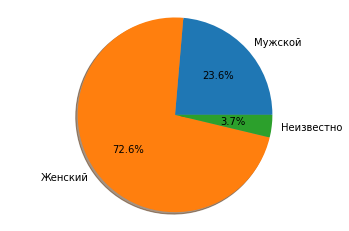

In [21]:
labels = ["Мужской", "Женский", "Неизвестно"]
sizes = [sum(df['Пол']==i) for i in ['м', 'ж', '-']]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.show()

Выборка смещена. Иногда мужчины также отвечали, что не могут ничего вспомнить.

## Распределение возраста

Возраста приводятся в форме приблизительного или точного (при соотнесении с событием) возраста, либо интервала. Интервалы в формате `начало диапазона-конец диапазона` приводим в форму двух чисел. Также имеются описания в которых используются не отрезки, а "лучи" времени (например, "не позже пяти", "после трех лет"). Все виды записей возраста представляются в виде списка словарей с ключами `float`, `range`, `more`, `less`.

In [22]:
#! некорректно обрабатывается строка вида '0.41-0.58; <1'
def age(age_str:'str'):
    '''Возвращает список разбитых на категории возрастов воспоминаний'''
    list_of_ages = []
    
    def age_float(s:'str'):
        list_of_ages.append({'float': float(s)})
    
    def age_range(s:'str'):
        r = [float(item) for item in s.split('-')]
        list_of_ages.append({'range': r})
        
    def age_not_single(s:str):
        if '-' in s:
            age_range(s)
        elif '<' in s:
            list_of_ages.append({'less': float(s[1:])})
        elif '>' in s:
            list_of_ages.append({'more': float(s[1:])})
        else:
            age_float(s)
    
    try:
        age_float(age_str)
    except ValueError:  #!! здесь блоки лучше заменить рекурсией или вызовом функции
        if ';' in age_str:
            for s in age_str.split(';'):
                age_not_single(s)
        else:
            age_not_single(age_str)
    
    return list_of_ages

In [23]:
age_df = df.loc[minus_or_smth('Возраст')[2].index]
age_df['age'] = age_df['Возраст'].apply(lambda x: age(x))

def age_dst_rough(age_list:list):
    '''Метод грубого разбиения возрастов:
    для диапазона используются средние значения интервалов,
    для лучевых отрезков (больше, меньше) - крайние точки'''
    age_rough_list = []
    for d in age_list:
        if 'float' in d:
            age = d['float']
        elif 'range' in d:
            age = sum(d['range'])/2
        elif 'less' in d:
            age = d['less']
        elif 'more' in d:
            age = d['more']
        else:
            age = None
        age_rough_list.append(age)
    return age_rough_list

# грубое разбиение возрастов
age_df['age'].apply(lambda x: age_dst_rough(x))

# минимальный возраст среди нескольких воспоминаний
age_df['min_age'] = age_df['age'].apply(lambda x: min(age_dst_rough(x)))

Число пустых ячеек: 17.
Число записей, не содержащих информации про возраст: 70.
Число записей, содержащих информацию про возраст: 556.


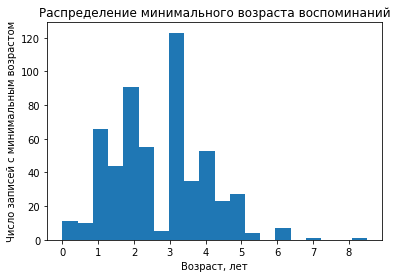

In [24]:


plt.title('Распределение минимального возраста воспоминаний')
plt.xticks(range(0, 9))
plt.xlabel('Возраст, лет')
plt.ylabel('Число записей с минимальным возрастом')
plt.hist(age_df['min_age'], bins=20)
plt.show()

## Уточнение возраста

Во многих случаях возраст не указан, но из самого текста воспоминания можно определить возрастаные границы. Маркерами возраста служат навыки, приобретаемые ребенкам. Для того, чтобы считать эти маркеры, можно использовать столбец «Ориентир возраста», в котором есть такие записи как "неумение ходить", "неумение говорить" и т.п.

Еще одним маркером, позволяющим уточнить возраст является то, что многие воспоминания связаны со встречей дня рождения. Это означает, что ребенку исполняется вполне конкретное число лет. В других случаях мы привыкли называть количество $n$ полных лет, но фактически это означает, что возраст представляет интервал $[n ... n+1)$.

Для "негрубого" построения необходимо найти подходящий тип визуализации, учитывающий "размазанность" интервалов.

# Ориентир возраста

In [26]:
df = get_df()

In [27]:
def get_comma_separated_items(column):
    '''Собирает строковые значения, разделенный запятыми в один общий список'''
    item_list = []
    for line in df[column]:
        if line:
            for item in line.split(','):
                item_list.append(item.strip())
    return item_list

In [28]:
cnt_age_orient = collections.Counter(get_comma_separated_items('Ориентир возраста'))
cnt_age_orient.most_common()

[('-', 338),
 ('детский сад', 32),
 ('подтверждение родственников', 28),
 ('день рождения', 25),
 ('переезд', 24),
 ('крещение', 12),
 ('место проживания', 12),
 ('смерть родственника', 12),
 ('Новый год', 11),
 ('рождение брата/сестры', 11),
 ('неумение ходить', 6),
 ('травма', 6),
 ('фотографии', 5),
 ('операция', 5),
 ('ясли', 3),
 ('развод родителей', 3),
 ('неумение говорить', 3),
 ('рождение', 3),
 ('внутреннее содержание', 3),
 ('обучение ходьбе', 2),
 ('первомайская демонстрация', 2),
 ('болезнь родственника', 2),
 ('фотография', 2),
 ('стеснение движений', 1),
 ('конкретный ориентир года', 1),
 ('отдых на море', 1),
 ('отъезд отца на заработки', 1),
 ('детский лагерь для малышей', 1),
 ('помощь родителей', 1),
 ('обучение чтению', 1),
 ('поход на байдарках', 1),
 ('ожог', 1),
 ('влюбленность', 1),
 ('первые шаги', 1),
 ('квартира', 1),
 ('землятресение', 1),
 ('возраст сестры', 1),
 ('смерть', 1),
 ('родители', 1),
 ('похороны', 1),
 ('чувство позднего времени воспоминания', 1

## Мотив

In [34]:
df = get_df()
cnt_age_orient = collections.Counter(get_comma_separated_items('Мотив'))
cnt_age_orient.most_common()

[('наблюдение', 57),
 ('игра', 37),
 ('прогулка', 35),
 ('на руках', 34),
 ('травма', 32),
 ('солнечный свет', 29),
 ('активность', 28),
 ('животное', 26),
 ('встреча дня рождения', 22),
 ('кровать', 20),
 ('обучение', 19),
 ('сидение', 18),
 ('испуг', 16),
 ('пробуждение', 14),
 ('крещение', 13),
 ('предмет', 13),
 ('телевизор', 12),
 ('ложное воспоминание', 12),
 ('смех', 11),
 ('стояние', 11),
 ('страх', 11),
 ('впервые', 11),
 ('быть везомым', 11),
 ('бег', 11),
 ('еда', 10),
 ('фотографирование', 10),
 ('встреча Нового года', 10),
 ('болезнь', 10),
 ('сон', 10),
 ('качание', 9),
 ('наблюдение родственника', 9),
 ('купание', 9),
 ('операция', 9),
 ('игрушка', 9),
 ('мысль', 8),
 ('укутывание', 8),
 ('путь до места', 8),
 ('лежание', 8),
 ('одежда', 7),
 ('движение', 7),
 ('взаимодействие с родственником', 7),
 ('одевание', 7),
 ('одежда с рисунком', 7),
 ('праздник', 6),
 ('плач', 6),
 ('темнота', 6),
 ('переезд', 6),
 ('рождение брата/сестры', 6),
 ('на коленях', 6),
 ('огромность

# Обработка текстуальной составляющей

[Документация pymorphy2](https://pymorphy2.readthedocs.io/en/latest/user/index.html)

## Распределение числа воспоминаний в записях

## Распределение объема воспоминаний
- по числу воспоминаний в записи
- по числу символов, слов, предложений
- по числу предложений, приходящихся на одно воспоминание

### Распределение числа символов в записях

In [ ]:
get_df()

In [ ]:
plt.xlim(left=0, right=1500)
plt.title('Распределение числа символов в записях')
plt.xlabel('Число символов')
plt.ylabel('Число записей')
plt.hist(df['Число символов'], bins=200)
plt.show()

## Среднее, минимальное и максимальное число символов, приходящееся на одно воспоминание

## Сколько предложений в среднем приходится на одно воспоминание?

In [ ]:
morph = pymorphy2.MorphAnalyzer()
get_df()
one_string = '\n\n'.join(df['Воспоминание'])

In [ ]:
# Найдем список всех слов

s = re.sub(r'[^a-zA-Zа-яА-Я0-9- ]', ' ', one_string)
# список всех слов корпуса текста (с повторами, в порядке появления)
words = s.split()  

In [ ]:
norm_words = []

for word in words:
    p = morph.parse(word)
    norm_words.append(p[0].normalized.word)

Сравним число исходных и нормализованных слов

In [ ]:
l = [len(words), len(set(words)), len(set(norm_words))]
print('Число слов в тексте: {}, с учетом повторов: {}, нормализованных с учетом повторов: {}.'.format(*l))

Посчитаем число слов, найдем самые распространенные, не относящиеся к союзам, предлогам, местоимениям, частицам и междометиям:

In [ ]:
word = 'я'
p = morph.parse(word)
str(p[0].tag.POS)

In [ ]:
import collections

cnt = collections.Counter(norm_words)
not_value_gram = ['NPRO', 'CONJ', 'PREP', 'PRCL', 'INTJ']

# Обнулим счетчик для слов тех частей речи, что относятся к перечисленным
for key in cnt.keys():
    p = morph.parse(key)
    if str(p[0].tag.POS) in not_value_gram:
        cnt[key] = -1
        
print(cnt.most_common(20))

## Проверка на опечатки

С помощью `pymorphy` было бы полезно поискать случаи, когда не находится нормальная форма слова – не опечатка ли это?

## Частотное распределение слов, приведенных к нормальной форме

## Сравнение ситуаций упоминания сущностей "мама, папа" и "родители"

## В каком времени написаны воспоминания? Прошедшем или настоящем? То есть с взглядом из текущего времени или с эмоциональным погружением в ситуацию?

Для этого можно рассмотреть время глаголов воспоминаний. В грубом приближении достаточно ориентироваться на, глаголы какого времени преобладают – настоящего или прошедшего.

# Поиск наиболее близких по содержанию текстов
Сравним тексты воспоминаний по близости друг к другу. Отыщем наиболее близкие пары текстов. Рассмотрим отдельно задачи а) близости записей и б) близости отдельных воспоминаний. 

# Генерация latex для верстки pdf 

Нужно создать инструмент для представления исходных данных и обработанных в верстке удобной для публикации в pdf (LaTeX), в виде статьи на Medium, в fb2, epub-форматах с заголовками и содержанием. Также необходимо инструмент перечисления номеров воспоминаний - замена последовательности на соответствующие ссылки-якоря

# Сохранение результатов
Обработанный набор данных сохранив в виде отдельного датасета.